In [24]:
## loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from multiprocessing import Pool
from glob import glob
import fitz
from PIL import Image
import os
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
import random
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praveen.shahani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv(r'C:\Users\praveen.shahani\Downloads\oxml2023mlcases-esg-classifier (1)\data\labels.csv')
df.head()

,id,class
0,report_519.pdf.53,governance
1,report_1537.pdf.24,social
2,report_567.pdf.33,governance
3,report_1830.pdf.220,other
4,report_1253.pdf.46,governance


In [5]:
df['class'].value_counts()

class
other            913
social           466
environmental    345
governance       232
Name: count, dtype: int64

In [6]:
pdfs = glob(r'C:\Users\praveen.shahani\Downloads\oxml2023mlcases-esg-classifier (1)\data\reports\*.pdf')
len(pdfs)

57

In [7]:
df['id'].value_counts()

id
report_1823.pdf.150    2
report_862.pdf.47      2
report_352.pdf.31      2
report_862.pdf.45      2
report_1823.pdf.149    2
                      ..
report_1829.pdf.39     1
report_1667.pdf.12     1
report_1825.pdf.313    1
report_1829.pdf.80     1
report_1833.pdf.55     1
Name: count, Length: 1951, dtype: int64

In [8]:
## extracting text from pdf and images
def visualize_pdf_image(filename, page_number):
    doc = fitz.open(filename)
    page_index = page_number - 1
    pix = doc[page_index].get_pixmap()
    img_page = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img_page 

In [9]:
data_path = r'C:\Users\praveen.shahani\Downloads\oxml2023mlcases-esg-classifier (1)\data\reports'

In [10]:
print(df['id'][0].split('pdf'))
df['id'][0].split('pdf')[0]+'pdf'

['report_519.', '.53']


'report_519.pdf'

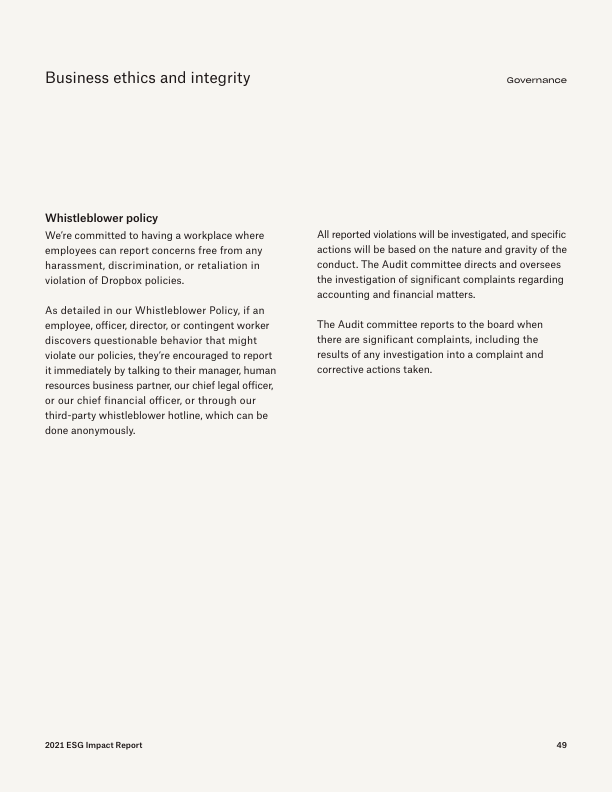

In [11]:
visualize_pdf_image(os.path.join(data_path, df['id'][0].split('pdf')[0]+'pdf'), 49)

In [12]:
# reading the page and printing the text
def read_page(filename,page_number):
    filepath = filename
    doc = fitz.open(filepath)
    page_index = page_number-1
    page = doc.load_page(page_index)
    return page.get_text()

In [13]:
text = read_page(os.path.join(data_path, df['id'][0].split('pdf')[0]+'pdf'), 49)
text

'2021 ESG Impact Report\n \n \n \n \n \n \n  \n \n \n  \n  \n \n \n \nBusiness ethics and integrity \nGovernance \nWhistleblower policy \nWe’re committed to having a workplace where \nemployees can report concerns free from any \nharassment, discrimination, or retaliation in \nviolation of Dropbox policies. \nAs detailed in our Whistleblower Policy, if an \nemployee, officer, director, or contingent worker \ndiscovers questionable behavior that might \nviolate our policies, they’re encouraged to report \nit immediately by talking to their manager, human \nresources business partner, our chief legal officer, \nor our chief financial officer, or through our \nthird-party whistleblower hotline, which can be \ndone anonymously. \nAll reported violations will be investigated, and specific \nactions will be based on the nature and gravity of the \nconduct. The Audit committee directs and oversees \nthe investigation of significant complaints regarding \naccounting and financial matters. \nTh

In [14]:
text = text.replace('\n','')
text

'2021 ESG Impact Report                 Business ethics and integrity Governance Whistleblower policy We’re committed to having a workplace where employees can report concerns free from any harassment, discrimination, or retaliation in violation of Dropbox policies. As detailed in our Whistleblower Policy, if an employee, officer, director, or contingent worker discovers questionable behavior that might violate our policies, they’re encouraged to report it immediately by talking to their manager, human resources business partner, our chief legal officer, or our chief financial officer, or through our third-party whistleblower hotline, which can be done anonymously. All reported violations will be investigated, and specific actions will be based on the nature and gravity of the conduct. The Audit committee directs and oversees the investigation of significant complaints regarding accounting and financial matters. The Audit committee reports to the board when there are significant compla

In [15]:
## step to clean the data
def get_text_by_row(row):
    filename,page = row['id'].split('pdf')
    page = int(page[1:])
    text = read_page(os.path.join(data_path,filename+'pdf'),page)
    return text.replace('\n','')


In [16]:
df['text']=df.apply(lambda row:get_text_by_row(row),axis=1)
df.head()

,id,class,text
0,report_519.pdf.53,governance,2021 ESG Impact Report Data ...
1,report_1537.pdf.24,social,242021 SUSTAINABILITY REPORTTABLE OF CONTENTSS...
2,report_567.pdf.33,governance,Sustainability GovernanceClean Harbors’ commit...
3,report_1830.pdf.220,other,220Report of the réviseur d’entreprises agréé•...
4,report_1253.pdf.46,governance,Pfizer 2021 ESG Report46GovernanceGovernance— ...


In [17]:
df['long_text']=df.text.apply(lambda x:len(x.split()))

In [18]:
df

,id,class,text,long_text
0,report_519.pdf.53,governance,2021 ESG Impact Report Data ...,243
1,report_1537.pdf.24,social,242021 SUSTAINABILITY REPORTTABLE OF CONTENTSS...,153
2,report_567.pdf.33,governance,Sustainability GovernanceClean Harbors’ commit...,310
3,report_1830.pdf.220,other,220Report of the réviseur d’entreprises agréé•...,549
4,report_1253.pdf.46,governance,Pfizer 2021 ESG Report46GovernanceGovernance— ...,674
...,...,...,...,...
1951,report_733.pdf.17,social,2021 Arista Corporate Responsibility Report |...,544
1952,report_1829.pdf.157,other,D _ Consolidated Financial StatementsAnnual...,961
1953,report_1825.pdf.295,other,293 I REGISTRATION DOCUMENT - ANNUAL REPOR...,216
1954,report_1830.pdf.77,other,Management report77The ArcelorMittal ordinary ...,690


In [19]:
## normalizing and cleaning for further analysis to do tokenization and embedding
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  

def normalize_and_clean_text(text):
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = text.split()
    
    stopwords_set = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwords_set]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    

    cleaned_text = " ".join(tokens)
    
    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praveen.shahani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\praveen.shahani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\praveen.shahani\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
df['cleaned_text'] = df['text'].apply(normalize_and_clean_text)
df['long_text_cleaned'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df[['text', 'cleaned_text', 'long_text', 'long_text_cleaned']].head()

,text,cleaned_text,long_text,long_text_cleaned
0,2021 ESG Impact Report Data ...,2021 esg impact report data privacy security r...,243,152
1,242021 SUSTAINABILITY REPORTTABLE OF CONTENTSS...,242021 sustainability reporttable contentssoci...,153,131
2,Sustainability GovernanceClean Harbors’ commit...,sustainability governanceclean harbor commitme...,310,203
3,220Report of the réviseur d’entreprises agréé•...,220report r viseur entreprises agr evaluate ap...,549,313
4,Pfizer 2021 ESG Report46GovernanceGovernance— ...,pfizer 2021 esg report46governancegovernance c...,674,443


In [21]:
df

,id,class,text,long_text,cleaned_text,long_text_cleaned
0,report_519.pdf.53,governance,2021 ESG Impact Report Data ...,243,2021 esg impact report data privacy security r...,152
1,report_1537.pdf.24,social,242021 SUSTAINABILITY REPORTTABLE OF CONTENTSS...,153,242021 sustainability reporttable contentssoci...,131
2,report_567.pdf.33,governance,Sustainability GovernanceClean Harbors’ commit...,310,sustainability governanceclean harbor commitme...,203
3,report_1830.pdf.220,other,220Report of the réviseur d’entreprises agréé•...,549,220report r viseur entreprises agr evaluate ap...,313
4,report_1253.pdf.46,governance,Pfizer 2021 ESG Report46GovernanceGovernance— ...,674,pfizer 2021 esg report46governancegovernance c...,443
...,...,...,...,...,...,...
1951,report_733.pdf.17,social,2021 Arista Corporate Responsibility Report |...,544,2021 arista corporate responsibility report 17...,369
1952,report_1829.pdf.157,other,D _ Consolidated Financial StatementsAnnual...,961,consolidated financial statementsannual report...,1072
1953,report_1825.pdf.295,other,293 I REGISTRATION DOCUMENT - ANNUAL REPOR...,216,293 registration document annual report 2018 a...,202
1954,report_1830.pdf.77,other,Management report77The ArcelorMittal ordinary ...,690,management report77the arcelormittal ordinary ...,456


In [26]:
# Assuming df is your DataFrame with 'cleaned_text' and 'class' columns
labels = df['class'].values
texts = df['cleaned_text'].values

# Prepare positive pairs for Multiple Negatives Ranking Loss (MNRL) training
grouped = {label: df[df['class'] == label]['cleaned_text'].tolist() for label in df['class'].unique()}
examples = []
for label, samples in grouped.items():
    num_pairs = min(100, len(samples) // 2)
    for _ in range(num_pairs):
        a, b = random.sample(samples, 2)
        examples.append(InputExample(texts=[a, b]))

# Load pre-trained model and fine-tune with MNRL loss
model = SentenceTransformer('all-MiniLM-L6-v2')
train_dataloader = DataLoader(examples, shuffle=True, batch_size=32)
train_loss = losses.MultipleNegativesRankingLoss(model)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=100
)

# Define classifiers
lgbm_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'random_state': 42
}

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'LightGBM': LGBMClassifier(**lgbm_params),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {name: {'accuracy': [], 'macro_f1': []} for name in classifiers.keys()}

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels), 1):
    print(f"\nFold {fold} -----------------------------")
    X_train, X_val = texts[train_idx], texts[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    emb_train = model.encode(X_train, show_progress_bar=False)
    emb_val = model.encode(X_val, show_progress_bar=False)

    for name, clf in classifiers.items():
        clf.fit(emb_train, y_train)
        y_pred = clf.predict(emb_val)

        acc = accuracy_score(y_val, y_pred)
        macro_f1 = f1_score(y_val, y_pred, average='macro')

        results[name]['accuracy'].append(acc)
        results[name]['macro_f1'].append(macro_f1)

        print(f"{name} Accuracy: {acc:.4f} | Macro F1: {macro_f1:.4f}")

# Summary table
summary = []
for name, scores in results.items():
    summary.append({
        'Model': name,
        'Mean Accuracy': np.mean(scores['accuracy']),
        'Std Accuracy': np.std(scores['accuracy']),
        'Mean Macro F1': np.mean(scores['macro_f1']),
        'Std Macro F1': np.std(scores['macro_f1'])
    })

results_df = pd.DataFrame(summary)
print("\nModel Comparison:\n", results_df)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss



Fold 1 -----------------------------
Logistic Regression Accuracy: 0.8520 | Macro F1: 0.8075
SVM Accuracy: 0.8648 | Macro F1: 0.8250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 1564, number of used features: 384
[LightGBM] [Info] Start training from score -1.734601
[LightGBM] [Info] Start training from score -2.134646
[LightGBM] [Info] Start training from score -0.761957
[LightGBM] [Info] Start training from score -1.433424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b